# Support Vector Machine (SMV)

### Integrantes

1. Cesar Avellaneda, 202214746, c.avellanedac@uniandes.edu.co.
2. Santiago Tinjaca, 202215991, s.tinjaca@uniandes.edu.co.
3. Jorge Bustamante,

Esto corresponde al noteBook del algoritmo SMV, que fue el algoritmo escogido.

Y contiene los siguientes elementos:
1. Cargue de los datos.

2. Entendimiento de los datos: Describir las características más relevantes de los datos y todo el perfilamiento de datos, incluir el análisis de calidad de datos y hacer una preselección de las variables más importantes para la etapa de modelado.

3. Preparación de datos: Solucionar los problemas de calidad de datos previamente identificados que afecten el modelo a construir. Además, debe aplicar todos los proceso de preprocesamiento de datos necesarios para la construcción del modelo de regresión.

4. Modelado: Utilizando las variables previamente seleccionadas, construir un modelo de regresión que estime la variable objetivo con el menor error posible.


# Entendimiento del Problema:

El problema principal radica en la necesidad de analizar de forma eficiente y automática grandes volúmenes de opiniones en lenguaje natural para relacionarlas con los ODS 3 (Salud y Bienestar), 4 (Educación de Calidad) y 5 (Igualdad de Género). Actualmente, este proceso es manual y requiere la intervención de expertos, lo que lo hace costoso y lento. La oportunidad consiste en desarrollar un modelo analítico automatizado que reduzca el tiempo y los recursos necesarios para este análisis, permitiendo una respuesta más rápida y efectiva a las necesidades de los ciudadanos.

# Enfoque Analitico:

Categoría de Análisis:
El análisis será predictivo y descriptivo. Descriptivo en el sentido de identificar y categorizar opiniones actuales, y predictivo al inferir tendencias y futuras necesidades o áreas de intervención.

Tipo y Tarea de Aprendizaje:
Aprendizaje Supervisado: Para clasificar las opiniones y relacionarlas con los ODS.

Técnicas y Algoritmos:
Modelos de Clasificación: SVM (Support Vector Machines).

# 1. Carga de los Datos:

In [2]:
import inflect
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
import pandas as pd
import numpy as np
import sys
import re, string, unicodedata
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.metrics import ConfusionMatrixDisplay
import spacy

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\santi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\santi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\santi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\santi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
entrevistasODS = pd.read_excel('./data/ODScat_345.xlsx')

# 2. Perfilamiento y entendimiento de datos:

Se puede ver que los datos recibidos se cuentan con 4049 registro con 2 columnas, el texto en español que corresponde a la opinion de las personas y el SDG indica a cual corresponde.

In [4]:
print(entrevistasODS.head())

                                      Textos_espanol  sdg
0  Por ejemplo, el nÃºmero de consultas externas ...    3
1  En 2007, el gobierno central financió directam...    3
2  Claramente, hay muchos otros factores en juego...    3
3  Por ejemplo, el estado australiano de Victoria...    3
4  El consumo anual de alcohol se estima en 15,7 ...    3


In [5]:
entrevistasODS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4049 entries, 0 to 4048
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Textos_espanol  4049 non-null   object
 1   sdg             4049 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 63.4+ KB


En el analisis de cada linea tiene en promedio 699 caractes, cada palabra maximo tiene 83 caracteres.

In [6]:
entrevistadosCopy = entrevistasODS.copy()
entrevistadosCopy['Conteo'] = [len(x) for x in entrevistadosCopy['Textos_espanol']]
entrevistadosCopy['Max'] = [[max([len(x) for x in i.split(' ')])][0] for i in entrevistadosCopy['Textos_espanol']]
entrevistadosCopy['Min'] = [[min([len(x) for x in i.split(' ')])][0] for i in entrevistadosCopy['Textos_espanol']]
entrevistadosCopy.describe()

,sdg,Conteo,Max,Min
count,4049.000000,4049.000000,4049.000000,4049.000000
mean,4.051124,699.632502,15.305508,0.967399
std,0.814338,228.988965,3.888995,0.208335
min,3.000000,294.000000,9.000000,0.000000
25%,3.000000,531.000000,14.000000,1.000000
50%,4.000000,657.000000,15.000000,1.000000
75%,5.000000,827.000000,16.000000,1.000000
max,5.000000,1513.000000,83.000000,2.000000


In [7]:
entrevistadosCopy

,Textos_espanol,sdg,Conteo,Max,Min
0,"Por ejemplo, el nÃºmero de consultas externas ...",3,944,18,1
1,"En 2007, el gobierno central financió directam...",3,476,14,1
2,"Claramente, hay muchos otros factores en juego...",3,1207,15,1
3,"Por ejemplo, el estado australiano de Victoria...",3,1090,17,1
4,"El consumo anual de alcohol se estima en 15,7 ...",3,895,13,1
...,...,...,...,...,...
4044,"Para ello, identificará las cuestiones de géne...",5,822,16,1
4045,La participación de las mujeres en roles de li...,5,514,16,1
4046,"Según el WEF, según las tendencias de 2016, po...",5,445,17,1
4047,"Sirve como recurso y foro para las agencias, c...",5,1017,15,1


# 3. Limpieza de Datos:

Definicmos las trasformaciones que se le harán a cada palabra, convertirlas en ascii, ponerlas en minuscula, eliminar puntuación.

In [8]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        if word is not None:
          new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
          new_words.append(new_word)
    return new_words

def to_lowercase(words):
    new_words=[]
    for word in words:
        w= word.lower()
        new_words.append(w)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        if word is not None:
            new_word = re.sub(r'[^\w\s]', '', word)
            if new_word != '':
                new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()    
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    spanish_sw = set(stopwords.words('spanish'))
    new_words = []
    for word in words:
        if word not in spanish_sw:
            new_words.append(word)
    return new_words


def preprocessing(words):
    words = to_lowercase(words)
    words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

In [9]:
entrevistasODS['palabras'] = entrevistasODS['Textos_espanol'].apply(word_tokenize)
entrevistasODS.head()

,Textos_espanol,sdg,palabras
0,"Por ejemplo, el nÃºmero de consultas externas ...",3,"[Por, ejemplo, ,, el, nÃºmero, de, consultas, ..."
1,"En 2007, el gobierno central financió directam...",3,"[En, 2007, ,, el, gobierno, central, financió,..."
2,"Claramente, hay muchos otros factores en juego...",3,"[Claramente, ,, hay, muchos, otros, factores, ..."
3,"Por ejemplo, el estado australiano de Victoria...",3,"[Por, ejemplo, ,, el, estado, australiano, de,..."
4,"El consumo anual de alcohol se estima en 15,7 ...",3,"[El, consumo, anual, de, alcohol, se, estima, ..."


In [10]:
entrevistasODS['palabras'].dropna()

0       [Por, ejemplo, ,, el, nÃºmero, de, consultas, ...
1       [En, 2007, ,, el, gobierno, central, financió,...
2       [Claramente, ,, hay, muchos, otros, factores, ...
3       [Por, ejemplo, ,, el, estado, australiano, de,...
4       [El, consumo, anual, de, alcohol, se, estima, ...
                              ...                        
4044    [Para, ello, ,, identificará, las, cuestiones,...
4045    [La, participación, de, las, mujeres, en, role...
4046    [Según, el, WEF, ,, según, las, tendencias, de...
4047    [Sirve, como, recurso, y, foro, para, las, age...
4048    [Las, áreas, útiles, para, un, mayor, estudio,...
Name: palabras, Length: 4049, dtype: object

In [11]:
entrevistasODS['palabras'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 4049 entries, 0 to 4048
Series name: palabras
Non-Null Count  Dtype 
--------------  ----- 
4049 non-null   object
dtypes: object(1)
memory usage: 31.8+ KB


In [12]:
entrevistasODS['palabras1']=entrevistasODS['palabras'].apply(preprocessing)
entrevistasODS.head()

,Textos_espanol,sdg,palabras,palabras1
0,"Por ejemplo, el nÃºmero de consultas externas ...",3,"[Por, ejemplo, ,, el, nÃºmero, de, consultas, ...","[ejemplo, naomero, consultas, externas, especi..."
1,"En 2007, el gobierno central financió directam...",3,"[En, 2007, ,, el, gobierno, central, financió,...","[two thousand and seven, gobierno, central, fi..."
2,"Claramente, hay muchos otros factores en juego...",3,"[Claramente, ,, hay, muchos, otros, factores, ...","[claramente, factores, juego, particular, vari..."
3,"Por ejemplo, el estado australiano de Victoria...",3,"[Por, ejemplo, ,, el, estado, australiano, de,...","[ejemplo, australiano, victoria, creo, agencia..."
4,"El consumo anual de alcohol se estima en 15,7 ...",3,"[El, consumo, anual, de, alcohol, se, estima, ...","[consumo, anual, alcohol, estima, 157, litros,..."


# Normalizar

In [13]:
nlp = spacy.load("es_core_news_sm")

stemmer = SnowballStemmer('spanish')

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmed_words = [stemmer.stem(word) for word in words]
    return stemmed_words

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmas = []
    for word in words:
        doc = nlp(word)
        for token in doc:
            if token.pos_ == 'VERB':
                lemmas.append(token.lemma_)
            else:
                lemmas.append(word)
    return lemmas

def stem_and_lemmatize(words):
    stems = stem_words(words)
    # lemmas = lemmatize_verbs(words)
    return stems


In [14]:
entrevistasODS['palabras1'] = entrevistasODS['palabras1'].apply(stem_and_lemmatize)
entrevistasODS.head()


,Textos_espanol,sdg,palabras,palabras1
0,"Por ejemplo, el nÃºmero de consultas externas ...",3,"[Por, ejemplo, ,, el, nÃºmero, de, consultas, ...","[ejempl, naomer, consult, extern, especial, th..."
1,"En 2007, el gobierno central financió directam...",3,"[En, 2007, ,, el, gobierno, central, financió,...","[two thousand and sev, gobiern, central, finan..."
2,"Claramente, hay muchos otros factores en juego...",3,"[Claramente, ,, hay, muchos, otros, factores, ...","[clar, factor, jueg, particul, varied, barrer,..."
3,"Por ejemplo, el estado australiano de Victoria...",3,"[Por, ejemplo, ,, el, estado, australiano, de,...","[ejempl, australian, victori, cre, agenci, pro..."
4,"El consumo anual de alcohol se estima en 15,7 ...",3,"[El, consumo, anual, de, alcohol, se, estima, ...","[consum, anual, alcohol, estim, 157, litr, ano..."


In [15]:
entrevistasODS['palabras'] = entrevistasODS['palabras1'].apply(lambda x: ' '.join(map(str, x)))
entrevistasODS


,Textos_espanol,sdg,palabras,palabras1
0,"Por ejemplo, el nÃºmero de consultas externas ...",3,ejempl naomer consult extern especial three hu...,"[ejempl, naomer, consult, extern, especial, th..."
1,"En 2007, el gobierno central financió directam...",3,two thousand and sev gobiern central financi d...,"[two thousand and sev, gobiern, central, finan..."
2,"Claramente, hay muchos otros factores en juego...",3,clar factor jueg particul varied barrer determ...,"[clar, factor, jueg, particul, varied, barrer,..."
3,"Por ejemplo, el estado australiano de Victoria...",3,ejempl australian victori cre agenci promocion...,"[ejempl, australian, victori, cre, agenci, pro..."
4,"El consumo anual de alcohol se estima en 15,7 ...",3,consum anual alcohol estim 157 litr ano hombr ...,"[consum, anual, alcohol, estim, 157, litr, ano..."
...,...,...,...,...
4044,"Para ello, identificará las cuestiones de géne...",5,ello identific cuestion gener mas destac malt ...,"[ello, identific, cuestion, gener, mas, destac..."
4045,La participación de las mujeres en roles de li...,5,particip mujer rol liderazg dentr legislatur t...,"[particip, mujer, rol, liderazg, dentr, legisl..."
4046,"Según el WEF, según las tendencias de 2016, po...",5,segun wef segun tendenci two thousand and sixt...,"[segun, wef, segun, tendenci, two thousand and..."
4047,"Sirve como recurso y foro para las agencias, c...",5,sirv recurs for agenci objet logr enfoqu integ...,"[sirv, recurs, for, agenci, objet, logr, enfoq..."


In [16]:
X_data, y_data = entrevistasODS['palabras'],entrevistasODS['sdg']
y_data

0       3
1       3
2       3
3       3
4       3
       ..
4044    5
4045    5
4046    5
4047    5
4048    5
Name: sdg, Length: 4049, dtype: int64

In [17]:
count = CountVectorizer()
X_count = count.fit_transform(X_data)
print(X_count.shape)
X_dense = X_count.toarray()
X_df = pd.DataFrame(X_dense, columns=count.get_feature_names_out())
X_df

(4049, 11793)


,001,003,004,005,006,007,009,01,015,016,...,zogl,zoles,zoll,zomb,zon,zonmw,zuck,zukowski,zupanc,zusatzentgelt
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4044,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4045,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4046,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4047,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# SMV

              precision    recall  f1-score   support

           3       0.97      0.98      0.98       372
           4       0.97      0.97      0.97       402
           5       0.98      0.98      0.98       441

    accuracy                           0.97      1215
   macro avg       0.97      0.97      0.97      1215
weighted avg       0.97      0.97      0.97      1215



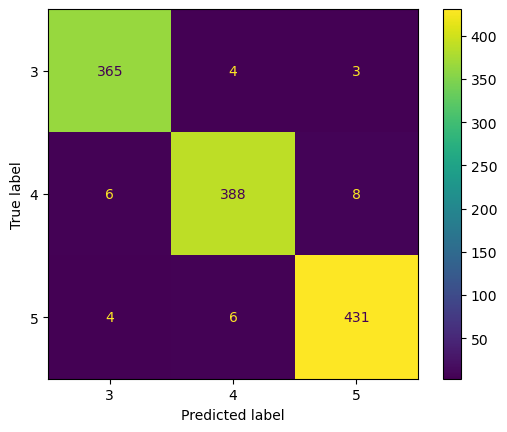

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_data, test_size=0.3, random_state=42)
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [19]:
coef = svm_model.coef_

feature_names = svm_model.feature_names_in_  
classes_n = svm_model.classes_
classes = [(3,4),(3,5),(4,5)]

word_importance = {class_label: np.zeros(len(feature_names)) for class_label in classes_n}

n_classifiers = coef.shape[0]

for i in range(n_classifiers):
    class_pair = classes[i]

    word_importance[class_pair[0]] += coef[i]
    word_importance[class_pair[1]] += -coef[i] 

for class_label, importance in word_importance.items():
    top_indices = np.argsort(importance)[-10:] 
    top_words = [feature_names[index] for index in top_indices]
    
    print(f"Clase: {class_label}")
    print("Palabras más importantes:", top_words)
    print("Coeficientes:", importance[top_indices])
    print()

Clase: 3
Palabras más importantes: ['consum', 'medicament', 'tratamient', 'atencion', 'medic', 'enfermedad', 'drog', 'pacient', 'sanitari', 'salud']
Coeficientes: [0.31863243 0.37243145 0.37918912 0.38311976 0.39009665 0.40662805
 0.41165145 0.42367793 0.53330036 0.71438411]

Clase: 4
Palabras más importantes: ['habil', 'maestr', 'alumn', 'ensen', 'profesor', 'docent', 'aprendizaj', 'escuel', 'estudi', 'educ']
Coeficientes: [0.30623457 0.31309484 0.31377747 0.32924402 0.39674029 0.41964844
 0.42597697 0.49804123 0.57013052 0.70402263]

Clase: 5
Palabras más importantes: ['derech', 'adolescent', 'iguald', 'chic', 'sexual', 'sex', 'femenin', 'muj', 'gener', 'mujer']
Coeficientes: [0.3493632  0.36156659 0.36793145 0.37131466 0.40510718 0.42990193
 0.43166086 0.65655414 0.97123908 1.03733064]



# Generar Predicciones

Usando el modelo generado anteriormente se le aplican las predicciones a los datos de test.

In [20]:
datos_sin_etiquetas = pd.read_excel('./data/TestODScat_345.xlsx')
datos_sin_etiquetas.head()

,Textos_espanol,sdg
0,Han examinado la contribuciÃ³n de las univers...,NaN
1,"En la última década, y en particular desde 201...",NaN
2,¿En qué países los estudiantes de alto rendimi...,NaN
3,A raíz de su preocupación por el hecho de que ...,NaN
4,"1999|H5|, Ares Abalde, 2014[ij]. El pequeño nú...",NaN


In [21]:
datos_sin_etiquetas['palabras'] = datos_sin_etiquetas['Textos_espanol'].apply(word_tokenize)
datos_sin_etiquetas['palabras'].dropna()
datos_sin_etiquetas['palabras1']=datos_sin_etiquetas['palabras'].apply(preprocessing)
datos_sin_etiquetas['palabras1'] = datos_sin_etiquetas['palabras1'].apply(stem_and_lemmatize)
datos_sin_etiquetas['palabras'] = datos_sin_etiquetas['palabras1'].apply(lambda x: ' '.join(map(str, x)))
datos_sin_etiquetas

,Textos_espanol,sdg,palabras,palabras1
0,Han examinado la contribuciÃ³n de las univers...,NaN,examin contribucia3n univers institu educacia3...,"[examin, contribucia3n, univers, institu, educ..."
1,"En la última década, y en particular desde 201...",NaN,ultim dec particul two thousand and t numer al...,"[ultim, dec, particul, two thousand and t, num..."
2,¿En qué países los estudiantes de alto rendimi...,NaN,pais estudi alto rendimient sient atra docenci...,"[pais, estudi, alto, rendimient, sient, atra, ..."
3,A raíz de su preocupación por el hecho de que ...,NaN,raiz preocup hech medic sistem sanitari japon ...,"[raiz, preocup, hech, medic, sistem, sanitari,..."
4,"1999|H5|, Ares Abalde, 2014[ij]. El pequeño nú...",NaN,1999h5 ares abald two thousand and fourt ij pe...,"[1999h5, ares, abald, two thousand and fourt, ..."
...,...,...,...,...
697,O puede darse de baja llamando a XXXXXXX o vis...,NaN,pued dars baj llam xxxxxxx visit www ensay con...,"[pued, dars, baj, llam, xxxxxxx, visit, www, e..."
698,Considere establecer o fortalecer la capacidad...,NaN,consider establec fortalec capac institu indep...,"[consider, establec, fortalec, capac, institu,..."
699,Varios líderes escolares habían decidido un te...,NaN,vari lider escolar habi decid tem aprendizaj p...,"[vari, lider, escolar, habi, decid, tem, apren..."
700,"Cada vez con más frecuencia, los traficantes d...",NaN,cad vez mas frecuenci trafic drog utiliz numer...,"[cad, vez, mas, frecuenci, trafic, drog, utili..."


In [22]:
X_data = datos_sin_etiquetas['palabras']

In [23]:
X_count = count.transform(X_data)
print(X_count.shape)
X_dense = X_count.toarray()
X_df = pd.DataFrame(X_dense, columns=count.get_feature_names_out())
X_df

(702, 11793)


,001,003,004,005,006,007,009,01,015,016,...,zogl,zoles,zoll,zomb,zon,zonmw,zuck,zukowski,zupanc,zusatzentgelt
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
697,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
698,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
699,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
700,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
y_pred = svm_model.predict(X_df)
y_pred

array([4, 3, 4, 3, 4, 4, 4, 3, 4, 4, 4, 3, 3, 3, 3, 3, 4, 4, 3, 4, 3, 4,
       3, 3, 4, 3, 4, 3, 4, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 4, 4, 4, 4,
       3, 4, 3, 4, 3, 3, 4, 3, 4, 4, 4, 4, 3, 4, 3, 4, 4, 3, 3, 3, 5, 3,
       3, 3, 5, 5, 3, 4, 4, 4, 4, 5, 4, 5, 4, 4, 3, 3, 3, 5, 4, 4, 4, 4,
       4, 5, 5, 4, 4, 5, 5, 5, 5, 4, 5, 4, 5, 3, 5, 3, 4, 5, 5, 3, 4, 4,
       4, 4, 5, 4, 4, 5, 5, 5, 5, 4, 3, 3, 4, 5, 3, 4, 5, 5, 4, 4, 3, 4,
       4, 5, 3, 4, 4, 4, 3, 4, 5, 5, 5, 4, 4, 4, 3, 3, 3, 4, 5, 3, 5, 3,
       3, 3, 4, 4, 4, 4, 4, 5, 3, 4, 5, 3, 3, 3, 4, 5, 4, 4, 5, 4, 4, 3,
       4, 3, 3, 4, 5, 3, 4, 3, 5, 4, 5, 5, 4, 5, 5, 5, 5, 4, 3, 4, 4, 5,
       5, 4, 4, 4, 4, 5, 5, 3, 4, 4, 5, 3, 4, 4, 5, 5, 3, 5, 3, 3, 5, 5,
       4, 4, 4, 4, 4, 5, 3, 3, 5, 4, 4, 3, 5, 5, 3, 4, 5, 5, 4, 5, 3, 3,
       3, 4, 5, 4, 5, 4, 5, 4, 5, 4, 4, 3, 3, 5, 4, 4, 3, 4, 5, 4, 5, 4,
       4, 3, 4, 4, 4, 5, 4, 5, 4, 4, 4, 5, 4, 5, 4, 5, 5, 3, 5, 5, 5, 3,
       4, 5, 3, 4, 4, 4, 5, 3, 5, 4, 4, 3, 4, 3, 3,

In [25]:
datos_predicion = pd.concat([datos_sin_etiquetas, pd.Series(y_pred, name = "sdg_prediccion")], axis = 1)
datos_predicion["sdg"] = datos_predicion["sdg_prediccion"]
datos_predicion.drop('sdg_prediccion',  axis='columns', inplace=True)
datos_predicion.drop('palabras',  axis='columns', inplace=True)
datos_predicion.drop('palabras1',  axis='columns', inplace=True)
datos_predicion

,Textos_espanol,sdg
0,Han examinado la contribuciÃ³n de las univers...,4
1,"En la última década, y en particular desde 201...",3
2,¿En qué países los estudiantes de alto rendimi...,4
3,A raíz de su preocupación por el hecho de que ...,3
4,"1999|H5|, Ares Abalde, 2014[ij]. El pequeño nú...",4
...,...,...
697,O puede darse de baja llamando a XXXXXXX o vis...,3
698,Considere establecer o fortalecer la capacidad...,5
699,Varios líderes escolares habían decidido un te...,4
700,"Cada vez con más frecuencia, los traficantes d...",3


Se Guardan en un archivo excel.

In [26]:
datos_predicion.to_excel("./data/predictODScat_345.xlsx")